/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0
Found 888 files belonging to 2 classes.
Using 666 files for training.
Using 222 files for validation.
37
['leeds', 'other']

Autotuning (much faster)


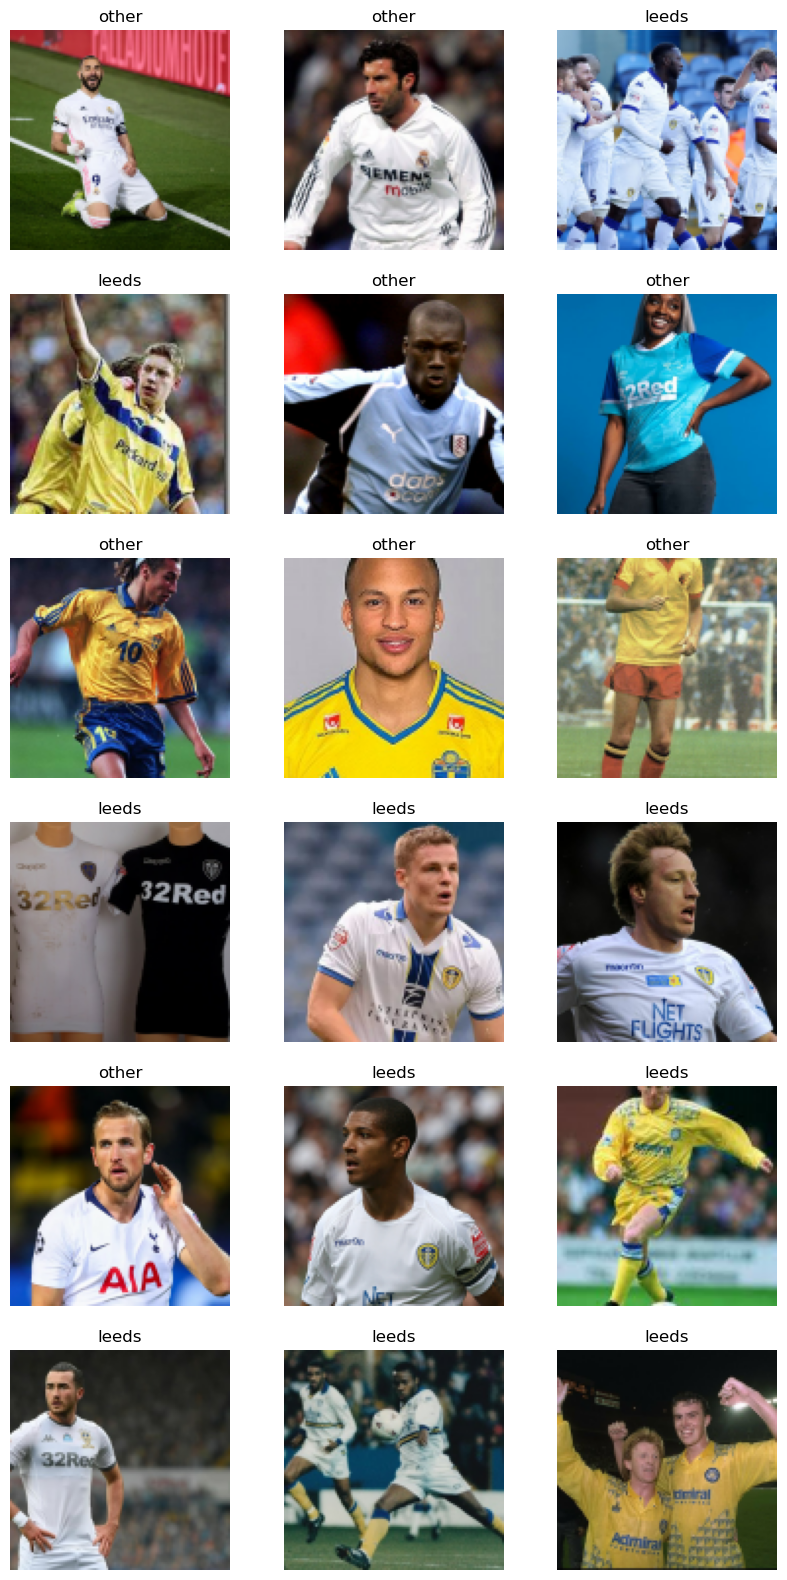

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib
import datetime

from tensorflow import keras
from tensorflow import data
from tensorflow.keras import utils

print(tf.__version__)

batch_size = 18 # Only reasonable factorization of 666

# Logging and model visualization stuff
output_model_for_netron = True # Don't save the model every time

running_tensorflow = False # Don't run it in Kaggle environment because Kaggle have disabled it for few years now
if running_tensorflow:
    # Clear any logs from previous runs, so we can put new ones in
    !rm -rf ./logs/ # TEMP not sure if this works, is illegal, etc
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Iterate through this list of models
model_list = ['my_custom_model', 'Xception', 'resnet']
model_list = ['my_custom_model', 'Xception']
#model_list = ['my_custom_model']
fine_tuning = False

# For now, the image size is independent of the CNN
# Define the shape of our inputs into the network
#img_height,img_width = 384,384
img_height, img_width = 224,224
img_height, img_width = 112,112

# Generates a tf.data.Dataset from image files in a directory.
# It expects to find a class structure. So if you have two directories, it will create two classes
train_ds, val_ds = utils.image_dataset_from_directory(
    '/kaggle/input/leeds-shirts/',
    labels = 'inferred',
    validation_split=0.25, # Should be 888-> 666 training files, = 222 validation files 
    subset="both", # Generates a tuple of training data and validation data
    seed=123,
    batch_size = batch_size,
    label_mode = 'binary', # This encodes labels as float32 scalars (i.e numpy objects) so I don't know how to convert them to int to print
    interpolation = 'area', # Not sure if this is the best
    shuffle = True, # Shuffle if we want to try with new data each time else fixed order
    image_size=(img_height, img_width),
    crop_to_aspect_ratio = True,
)

# Two ways to find out how many elements in the current batch
print(train_ds.cardinality().numpy()) 
#print(len(list(train_ds)))

# class_names is a list of classes
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 20))
for images, labels in train_ds.take(1):
  for i in range(batch_size): 
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # labels[i] is float32 scalars with values 0 or 1 (e.g. for binary_crossentropy).
    # So need convert from numpy ndarray to float and then int...    
    plt.title(class_names[int(labels[i].numpy()[0])])

    #plt.title(class_names[1]+'+'+class_names[0]) # This is fake coz don't know how to extract properly
    plt.axis("off")
    
autotune = True # No reason to turn this off. Three times quicker when on. Nothing to do with model type, right?
if autotune:
    AUTOTUNE = data.experimental.AUTOTUNE
    print("\nAutotuning (much faster)")
    train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)


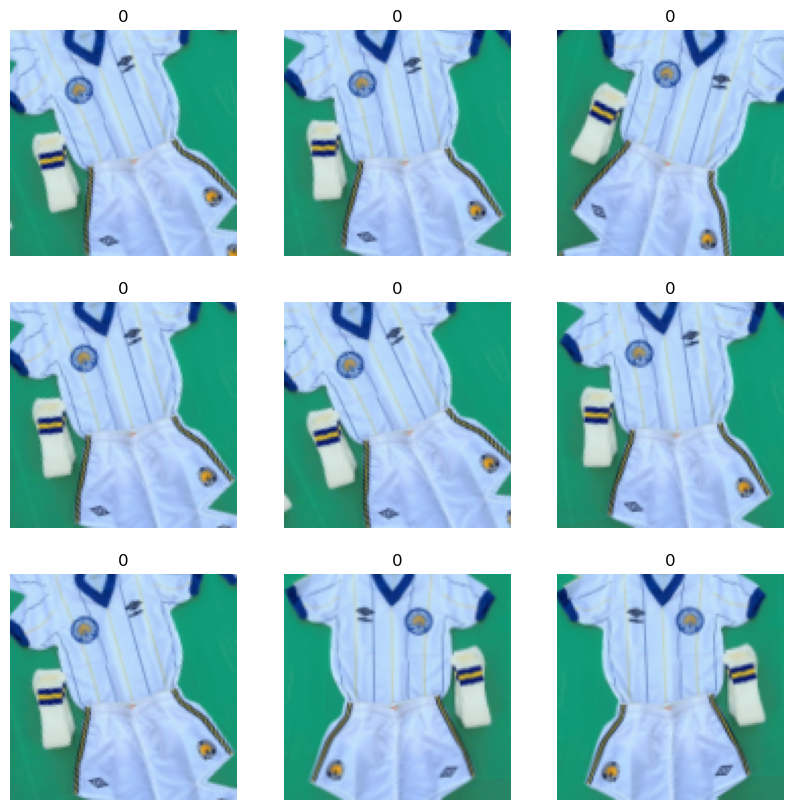

In [2]:
# Augmentation preperation code. Used in each model. And only needs to be done once, so place outside
# the main loop

from tensorflow import keras
from tensorflow.keras import layers 

# Create a data augmentation stage with horizontal flipping, rotations, etc
data_augmentation = keras.Sequential(
  [
    # They are only active during training.
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                img_width,
                                 3)),
    layers.RandomRotation(0.1),
    #layers.RandomZoom(0.1,0.1),
    #layers.RandomTranslation(0.2,0.2),
  ]
)

# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")
    
# 2nd bit of code to display augmented images. Is this same result??
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")
        
        


In [3]:
# create_model() definition
# returns: model
# Nothing to run in here, sorry
from tensorflow import keras
from tensorflow.keras import layers 

def create_model(model_type):
    if model_type == 'my_custom_model':
        sigmoid_initializer = 'glorot_normal'
        relu_initializer = 'he_normal' # Never use glorot_normal in relu_initializer
        kernel_regularizer = None # Can change this to 'L2' or whatever if want to use it
        # I basically tried to emulate vgg16
        print("Doing the lee_custom_model_ dance (with no initial weights, it's a virgin net)")
        model = keras.Sequential()
        # Block One
        model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
        model.add(layers.Conv2D(filters=64,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_regularizer = kernel_regularizer,
                  kernel_initializer = relu_initializer,
                  name = '1st_Conv2D_Layer',))
        model.add(layers.Dropout(0.1))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
        # Block Two
        model.add(layers.Conv2D(filters=128,
                          kernel_size=3,
                          activation='relu',
                          padding='same',
                          kernel_regularizer = kernel_regularizer,
                          kernel_initializer = relu_initializer,))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
        # Block Three
        model.add(layers.Conv2D(filters=256,kernel_size=3,activation='relu',padding='same',
                                kernel_regularizer = kernel_regularizer, kernel_initializer = relu_initializer,))
        model.add(layers.Dropout(0.1))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
        model.add(layers.Dropout(0.5))
        model.add(layers.BatchNormalization())
        # Block Four - now at 14
        model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same',
                                kernel_regularizer = kernel_regularizer, kernel_initializer = relu_initializer,))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
         # Block Five - now at 7
        model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same',
                                kernel_regularizer = kernel_regularizer,kernel_initializer = relu_initializer,))  
        model.add(layers.Dropout(0.1))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2,2)))
        # Head
        # Always need to flatten because Keras requires a 1D array as input to dense layers
        model.add(layers.Flatten(name = 'flatten_before_dense'),)
        # 1st dense layer
        model.add(layers.Dense(units=4096,activation='relu',kernel_regularizer = kernel_regularizer,kernel_initializer = relu_initializer,
                         name = '1st_Dense_Layer',),)
        model.add(layers.Dropout(0.5),)
        model.add(layers.BatchNormalization())
        # 2nd dense layer
        model.add(layers.Dense(units=4096,activation='relu',kernel_regularizer = kernel_regularizer,kernel_initializer = relu_initializer,
                         name = '2nd_Dense_Layer',),)
        model.add(layers.Dropout(0.5),)
        model.add(layers.BatchNormalization())
        # Output layer
        model.add(layers.Dense(units = 1, # Single layer coz binary classification ✅
                         activation = 'sigmoid',
                         kernel_initializer = sigmoid_initializer,))
    elif model_type == 'Xception':
        print("Doing the Xception dance (using imagenet weights for now)")
        # First, instantiate a base model with pre-trained weights
        base_model = keras.applications.Xception(
            weights = 'imagenet',
            input_shape = (img_width,img_height,3),
            include_top = False,
        ) # Cut off the top coz I want binary layer

        # Feeze the base model.
        base_model.trainable = False

        # Create a new model on top.
        inputs = keras.Input(shape=(img_width,img_height,3))
        x = data_augmentation(inputs) # Apply random data augmentation

        # Pre-trained Xception weights requires that input be scaled
        # from (0, 255) to a range of (-1., +1.), the rescaling layer
        # outputs: `(inputs * scale) + offset`
        scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
        x = scale_layer(x)

        # The base model contains batchnorm layers. We want to keep them in inference mode
        # when we unfreeze the base model for fine-tuning, so we make sure that the
        # base_model is running in inference mode here.
        x = base_model(inputs, training=False)
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
        # A Dense classifier with a single unit (binary classification)
        outputs = keras.layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)
        model.summary()
    else:
        print("Don't have a model. Not good.")
    return model
    #for layer in model.layers:
    #    print(layer.name, layer)

In [4]:
# history_visualizer() definition.
# Returns: nothing
# Nothing to run in here, sorry

def visualizer_fitting_results(history, binary = True):
    # Input is a history object. The result of running fit()
    # Visualize the loss and accuracy over the last number of epochs
    
    print(history)
    print(history.params)
    print(type(history))
    print(history.history)
    print(type(history.history))
    print(history.history.keys())
    
    print(history.history['val_binary_accuracy'])
    if binary:
        acc = history.history['binary_accuracy']
        val_acc = history.history['val_binary_accuracy']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc)) # Can't use range(epochs) coz earlystopping might prevent #epochs reaching 'epoohs'

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [5]:
# compile_and_fit_model() definition.
# Returns a history object
# Nothing to run in here, sorry
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
 
def compile_and_fit_model(model,epochs, learning_rate, patience):
    # Must have the right code for all potential models we run
    if model_type == 'my_custom_model':
        model.compile(
            loss= "binary_crossentropy",
            optimizer = optimizers.Adam(
        # Learning_rate is very important right? Reduce this and model learns slower but more accurately.
                learning_rate = learning_rate, 
                epsilon = 0.1,
            ),
        metrics=['binary_accuracy'],)
    elif model_type == 'Xception':
        model.compile(optimizer=keras.optimizers.Adam(
                learning_rate = learning_rate),
    # Whether to interpret y_pred as a tensor of logit values.
    # By default, we assume that y_pred contains probabilities (i.e., values in [0, 1]).
    # Not sure why we need from_logits=True for Xception model but false for my own model.
                  loss=keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[keras.metrics.BinaryAccuracy()])
    else:
        print("We don't have compilation code for this model. oops")

    early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                            patience = patience,
                                            min_delta = 0.00,
                                            restore_best_weights = True,
                                            verbose = 1,
                                            start_from_epoch = 3,)
  
    if running_tensorflow:
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        callback = [
            early_stopping,
            tensorboard_callback,
        ]
    else:
        callback = [
        early_stopping,
        ]
    
    # Fit the model i.e. train the model for a fixed number of epochs
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = epochs,
        verbose = 1,
        callbacks = [callback])

    print("\nFinished fitting the model")
    return history




Doing the lee_custom_model_ dance (with no initial weights, it's a virgin net)
37/37 [==============================] - 78s 2s/step - loss: 0.9098 - binary_accuracy: 0.4820 - val_loss: 0.6948 - val_binary_accuracy: 0.4865

Finished fitting the model
{'verbose': 1, 'epochs': 1, 'steps': 37}
<class 'keras.callbacks.History'>
{'loss': [0.9098365306854248], 'binary_accuracy': [0.4819819927215576], 'val_loss': [0.6947707533836365], 'val_binary_accuracy': [0.4864864945411682]}
<class 'dict'>
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
[0.4864864945411682]


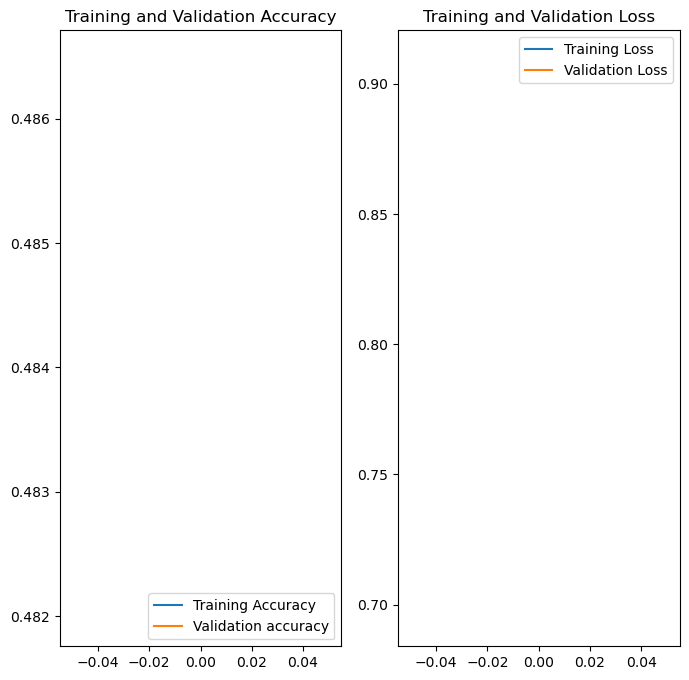

Doing the Xception dance (using imagenet weights for now)
83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Tota

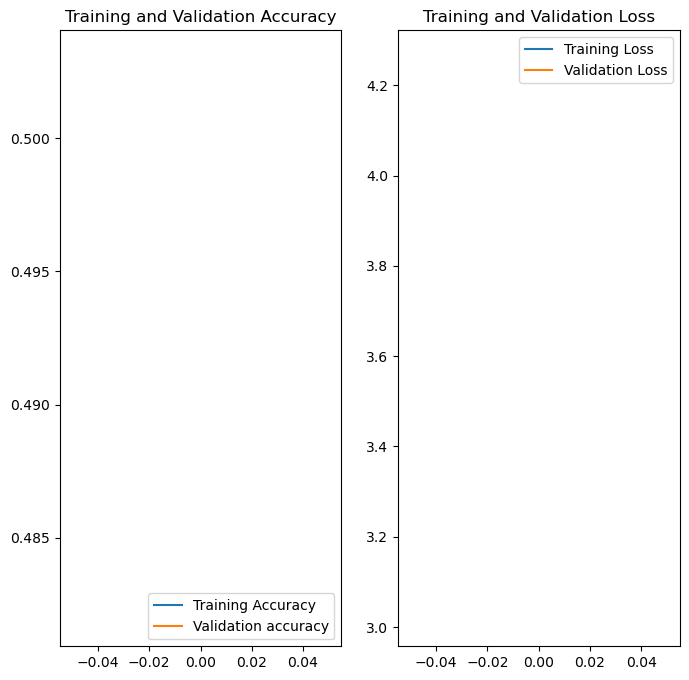

Out of the main loop now. Success!


In [6]:
# Model creation, compilation, and fitting (running) loop
# Should loop round all models we have in our main list
from tensorflow.keras import utils
for model_type in model_list:
    model = create_model(model_type)
    # N.B. Print this if want to spy on initial weights
    # print(model.layers[1].weights) 
    #model.summary()
    #utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_activations=True)
    history = compile_and_fit_model(model,epochs=1,learning_rate=0.001,patience=5)
    #print(model.layers[1].weights) 
    # TEMP problem with doing it here is that I can't re-reun that. Can run only once. Kinda Sucky
    visualizer_fitting_results(history,binary=True)
print("Out of the main loop now. Success!")


In [7]:
if output_model_for_netron:
    model_save_name = 'test_model.keras'
    model.save(model_save_name)
    from IPython.display import FileLink
    FileLink(model_save_name)
    print("Created link for downloading. Cool")


Created link for downloading. Cool


In [8]:
# "Do a round of fine-tuning of the entire model"
# This is an optional last step that can potentially give you incremental improvements.
# It could also potentially lead to quick overfitting -- keep that in mind.
# It is critical to only do this step after the model with frozen layers has been trained to convergence. 
#  If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features,
# the randomly-initialized layers will cause very large gradient updates during training,
# which will destroy your pre-trained features.

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

# TEMP
# Only run this code for Xception AND already done 

if model_type == 'Xception' and fine_tuning:
    base_model.trainable = True
    model.summary()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    # Whether to interpret y_pred as a tensor of logit values.
    # By default, we assume that y_pred contains probabilities (i.e., values in [0, 1]).
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )
    epochs = 10
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    visualizer_fitting_results(history, True)